In [257]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
%matplotlib inline

In [258]:
#1.1
#加载所需的数据
data1 = xr.open_dataset(r"D:\ESE5023\NOAA_NCDC_ERSST_v3b_SST.nc")
#选择Niño 3.4 region，经纬度范围(5N-5S, 170W-120W)，西经的换算180+|180-x|，并按月份分组
data_range=data1.sst.sel(lat=slice(-5,5),lon=slice(190,240)).groupby('time.month')
#求该区域的月平均
sst_month_mean =data_range.mean(dim=['lat', 'lon','time'])
#相减求该区域的异常值
sst_anom=data_range-sst_month_mean
#求3个月的滑动平均（ 3-month running mean）
#窗口大小为3（每个月1个数据），窗口的标签设置为居中，每个窗口内最少包含的观测值的数量为2（为了头尾数据不为空）
sst_mean_3=sst_anom.rolling(time=3, center=True, min_periods=2).mean()
#得到异常值
sst_anomalies=sst_mean_3.mean(dim=['lat', 'lon'])

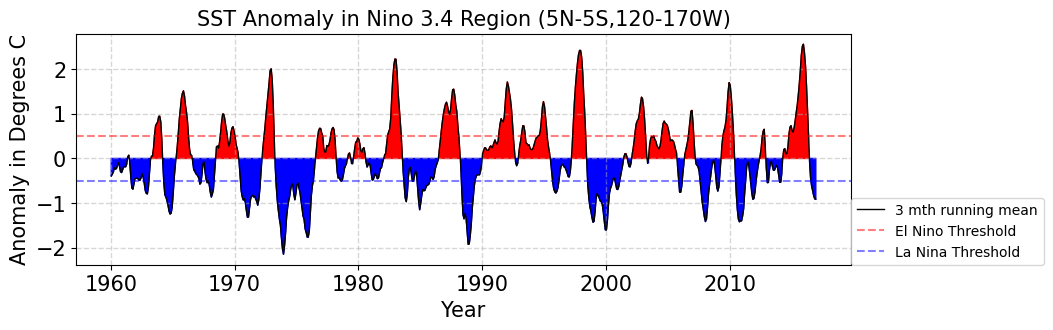

In [259]:
#1.2
#调整画布大小，线段颜色为黑色，线粗细为1
plt.figure(figsize=(10,3),dpi=100)
plt.plot(data1.sst.time,sst_anomalies,'k',linewidth=1, label = '3 mth running mean')
#调整xy轴
plt.xticks(fontsize=15)
plt.yticks(ticks=np.arange(-3,4,1), fontsize=15)
#画网格线
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
#加标题
plt.title('SST Anomaly in Nino 3.4 Region (5N-5S,120-170W)', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Anomaly in Degrees C', fontsize=15)
#填充红蓝色
plt.fill_between(data1.sst.time.to_numpy(),sst_anomalies,where=(sst_anomalies>0),color='red')
plt.fill_between(data1.sst.time.to_numpy(),sst_anomalies,where=(sst_anomalies<0),color='blue')
#添加±0.5的标记线
plt.axhline(y = 0.5, ls = '--', color = 'red', alpha = 0.5, label = 'El Nino Threshold')
plt.axhline(y = -0.5, ls = '--', color = 'blue', alpha = 0.5, label = 'La Nina Threshold')
#在右下角添加图例
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)

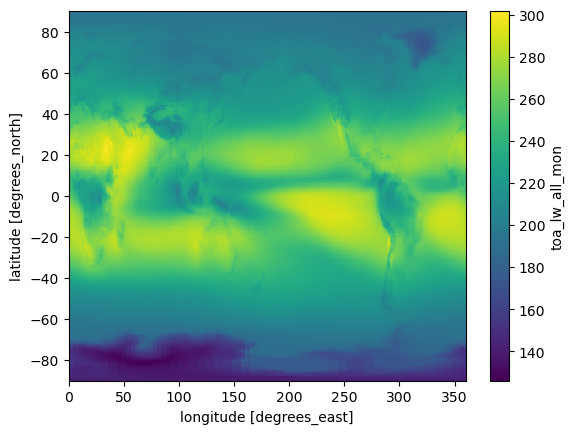

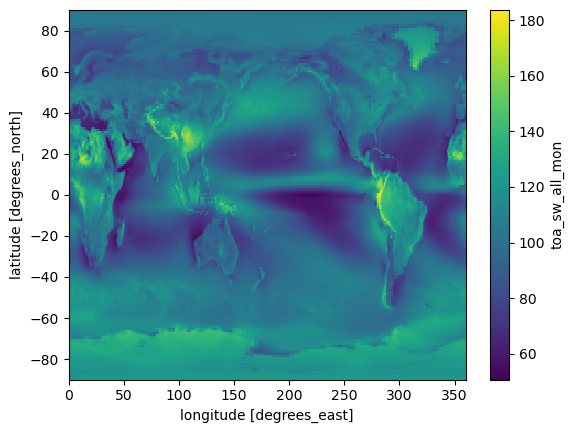

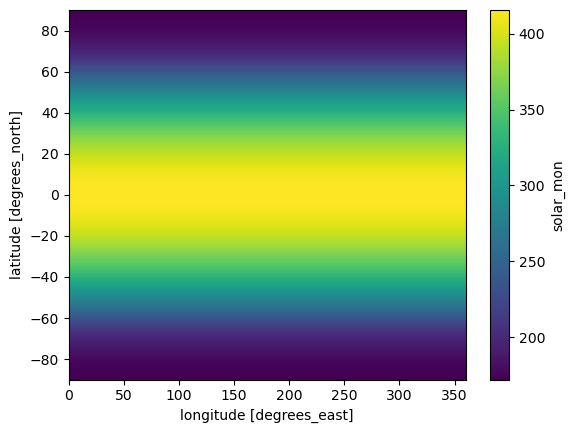

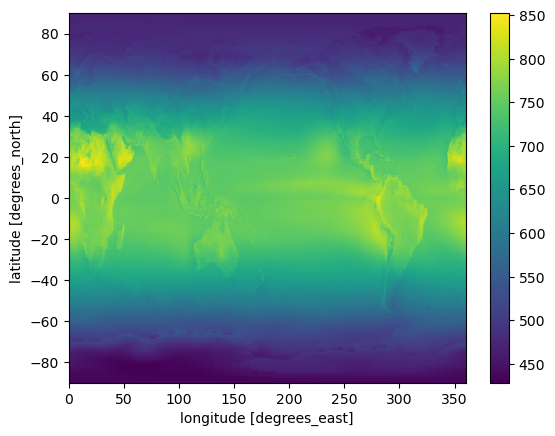

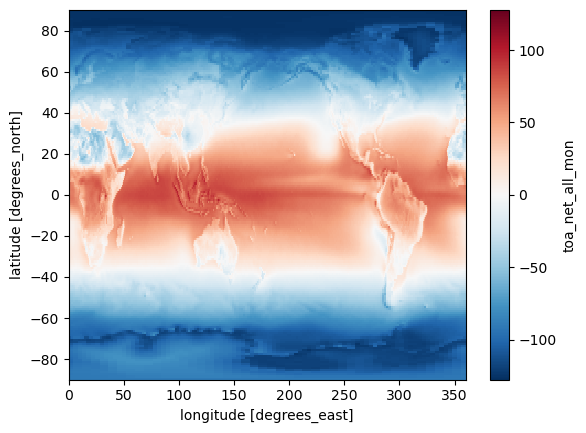

In [260]:
#2.1
#加载所需的数据
data2 = xr.open_dataset(r"D:\ESE5023\CERES_EBAF-TOA_200003-201701.nc")
# Time-mean TOA longwave
data2.toa_lw_all_mon.mean(dim='time').plot()
plt.show()
# Time-mean TOA shortwave
data2.toa_sw_all_mon.mean(dim='time').plot()
plt.show()
# 太阳辐射 Solar radiation
data2.solar_mon.mean(dim='time').plot()
plt.show()
# 以上三个相加 Add up the three variables above
data2_add=data2.toa_lw_all_mon.mean(dim='time')+data2.toa_sw_all_mon.mean(dim='time')+data2.solar_mon.mean(dim='time')
data2_add.plot()
plt.show()
#与TOA net flux比较
data2.toa_net_all_mon.mean(dim='time').plot()
plt.show()

In [261]:
#2.2
#weights
weights = np.cos(np.deg2rad(data2.lat))
data2.solar_mon.mean(dim = 'time').weighted(weights).sum()  #太阳辐射：14037950
data2.toa_lw_all_mon.mean(dim = 'time').weighted(weights).sum()  #长波：9911886
data2.toa_sw_all_mon.mean(dim = 'time').weighted(weights).sum()  #短波：4089832.2
#太阳辐射总量=14037950，短波总量+长波总量=14001718，approximately match

<xarray.DataArray 'toa_sw_all_mon' ()>
array(4089832.2, dtype=float32)

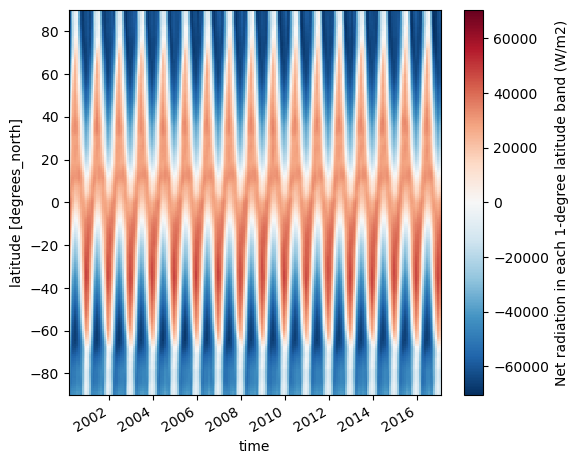

In [262]:
#2.3
#对纬度所在的所有经度范围加和，翻转（后续画图x轴为时间，y轴为纬度）
net_radiation=data2.toa_net_all_mon.sum(dim=['lon']).transpose()
#画图，备注单位“W/m2”
net_radiation.plot(figsize=(6,5),cbar_kwargs={'label':'Net radiation in each 1-degree latitude band (W/m2)'})

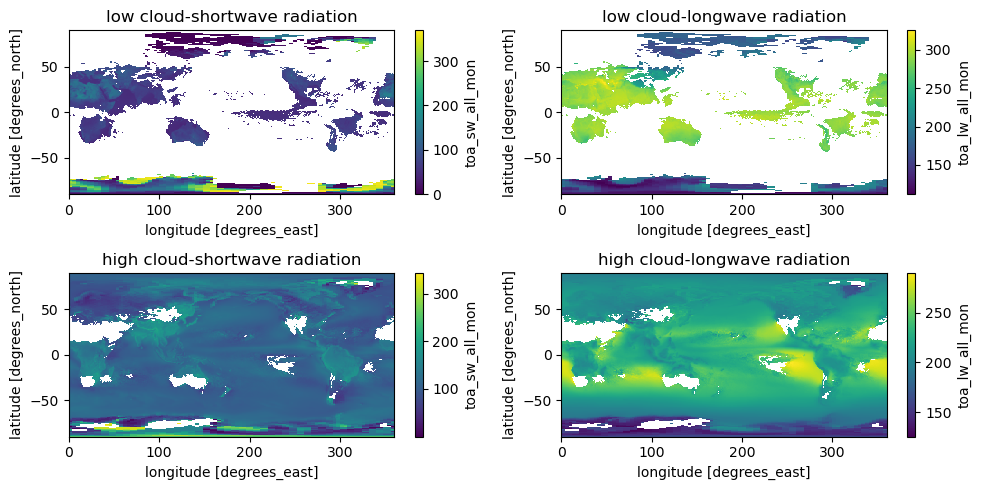

In [263]:
#2.4
#设置4个图
fig,axs= plt.subplots(2,2,figsize=(10, 5))
#low cloud area as ≤25%, high cloud area as ≥75%
low_short=data2.toa_sw_all_mon.where(data2.cldarea_total_daynight_mon<=25).mean(dim = 'time')
low_long=data2.toa_lw_all_mon.where(data2.cldarea_total_daynight_mon<=25).mean(dim = 'time')
high_short=data2.toa_sw_all_mon.where(data2.cldarea_total_daynight_mon>=75).mean(dim = 'time')
high_long=data2.toa_lw_all_mon.where(data2.cldarea_total_daynight_mon>=75).mean(dim = 'time')
#分别放入4个小图
low_short.plot(ax = axs[0,0])
low_long.plot(ax = axs[0,1])
high_short.plot(ax = axs[1,0])
high_long.plot(ax = axs[1,1])
#设置图标题low/high cloud - shortwave/longwave radiation
axs[0,0].set_title('low cloud-shortwave radiation')
axs[0,1].set_title('low cloud-longwave radiation')
axs[1,0].set_title('high cloud-shortwave radiation')
axs[1,1].set_title('high cloud-longwave radiation')
#画图
fig.tight_layout()

In [264]:
#2.5
low_short.mean() #88.81645
low_long.mean() #233.06702
high_short.mean() #114.74328
high_long.mean() #215.37349
# The increase in clouds increases shortwave radiation and decreases longwave radiation

<xarray.DataArray 'toa_lw_all_mon' ()>
array(215.37349, dtype=float32)

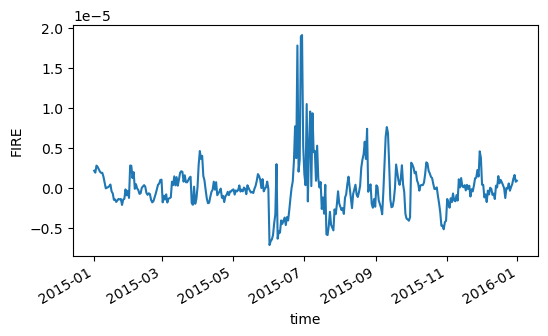

In [265]:
#3.1
#加载所需的数据
data3 = xr.open_dataset(r"D:\ESE5023\GEOSCarb_CASAGFED3v3_Fire.Daily.x720_y360.2015.nc", engine="netcdf4")
#按月分组
data3_1= data3.FIRE.groupby('time.month')
#相减求该区域的异常值
FIRE_anom=data3_1-data3_1.mean(dim='time')
FIRE_anomalies=FIRE_anom.mean(dim=['latitude', 'longitude'])
#画图
FIRE_anomalies.plot(figsize=(6, 3))

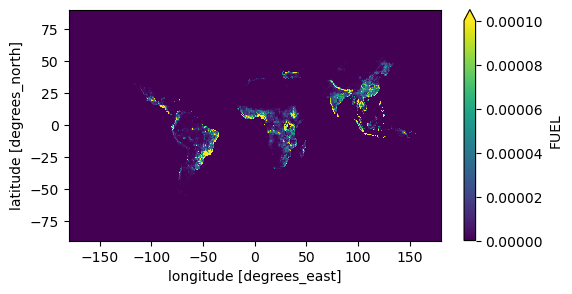

In [266]:
#3.2
#3.2.1：Fuel的平均值
FUEL_mean=data3.FUEL.mean(dim='time')
FUEL_mean.plot(figsize=(6, 3),vmin=0,vmax=0.0001)

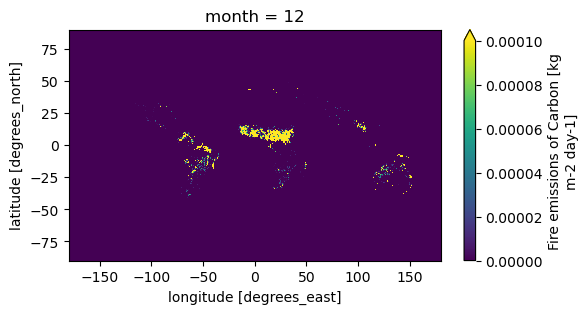

In [267]:
#3.2.2：Fire Assimilation of C在12月的平均值
FIRE_12_mean=data3.FIRE.groupby('time.month').mean().sel(month=12)
FIRE_12_mean.plot(figsize=(6, 3),vmin=0,vmax=0.0001)

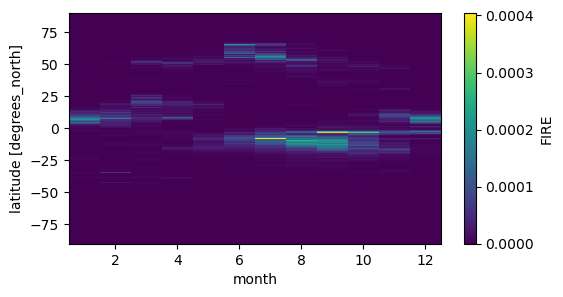

In [268]:
#3.2.3：不同纬度下Fire Assimilation of C的月平均
lat_mean=data3.FIRE.groupby('time.month').mean().mean(dim='longitude').transpose()
lat_mean.plot(figsize=(6, 3))

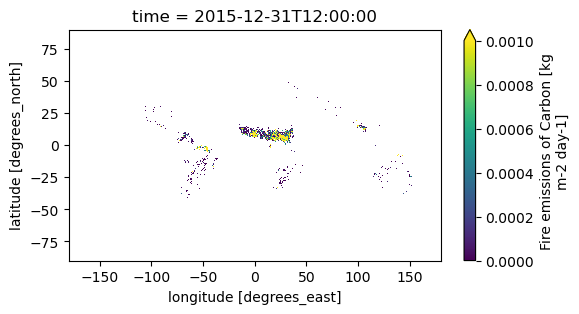

In [269]:
#3.2.4：数据最后一天（2015.12.31）Fire Assimilation of C大于0.001的地区
day_1=data3.FIRE.isel(time=-1)
day_1_FIRE=day_1.where(sample > 0.00000001)
day_1_FIRE.plot(figsize=(6, 3),vmin=0,vmax=0.001)

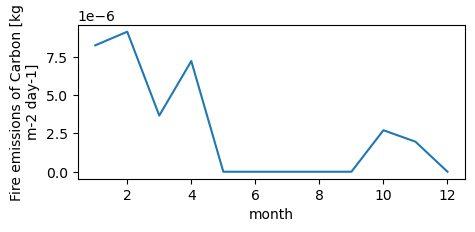

In [270]:
#3.2.5：广东地区（北纬20°～25°东经109°～117°）Fire Assimilation of C的月平均
gd_data3=data3.FIRE.sel(longitude=slice(109, 117), latitude=slice(20,25)).groupby('time.month').mean(dim=['latitude', 'longitude','time'])
gd_data3.plot(figsize=(5, 2))